# ASTR 21100 

# *"Computational Techniques in Astrophysics"*

## Instructor: Andrey Kravtsov

### office: ERC 415; email: kravtsov@uchicago.edu
### office hours: Tue, 10:30am-noon (unless noted otherwise)

### Teaching Assistants: 
### Dimitrios Tanoglidis (dtanoglidis@uchicaago.edu)
### Georgios Zakharegkas (gzakharegkas@uchicago.edu)

Some of you have expressed interest in how Jupyter notebooks can be used for slide shows. There are a few ways of doing this. The method I use is based on the RISE extension, which is available and described <a href="https://github.com/damianavila/RISE">here</a>. In particular, you can watch a <a href="https://www.youtube.com/watch?v=sXyFa_r1nxA">mini tutorial video</a> to learn the basics of how this is done. 

### What we have been talking about so far: 

* computation of distances to distant objects in astronomy
* Taylor expansion of functions and truncation errors
* Roundoff errors
* numerical integration using trapezoidal and general powerful Romberg scheme to compute distances in general cosmological models
* making plots in a good scientific style

### This week: 

* approximation of functions using physical model predictions
* approximation of functions using polynomials
* dependence of approximation on the points at which function is tabulated
  equally-spaced tabulation points vs Chebyshev nodes
* approximating functions using piecewise polynomial approximation
* piecewise approximation using spline polynomials
* general approach to approximate functions with basis function expansion
* approximating functions using B-splines as basis functions
* connection to future topics: approximation of functions using trigonometric series, Fourier series, and wavelets 

### Example of model approximating data

the plot I showed you two weeks ago (from <a href="https://ui.adsabs.harvard.edu/abs/2012ApJ...746...85S/abstract">Suzuki et al. 2012</a>) for <a href="https://en.wikipedia.org/wiki/Type_Ia_supernova">type Ia supernovae</a>.

<br>
<center><img width=1000 src="img/suzuki_etal12_hubble_diagram.png"></img></center>

In [1]:
import numpy as np

In [2]:
# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

### Building a package of useful routines 

To avoid the need to paste and copy useful plotting routines that were introduced and developed in the previous weeks, I copied them to python file in <tt>codes/plot_utils.py</tt> and added it to the repository. 

The <tt>codes/</tt> subdirectory also holds <tt>__init__.py</tt> file, which makes <tt>codes</tt> subdirectory a package, from which I can import modules and specific routines, just like we do this from numpy. 

In [3]:
from codes.plot_utils import plot_pretty

plot_pretty(fontsize=12)


### Model $d_L(z, H_0, \Omega_0, \Omega_\Lambda)$ vs supernova type Ia data

Recall from last week that supernovae type Ia are thought to be nearly "standard candles", which means that their intrinsic luminosity is nearly constant for all supernovae. Intrinsic luminosity in astronomy is often measured using absolute magnitude, $M$. 

The *distance modulus* - the difference of the observed *apparent magnitude* and absolute magnitude is a function of distance: 

$$\mu = m - M = 5\log_{10}d_L + 25.$$

Now we can compute $d_L$ for theoretical model and compare it to observed $\mu_{\rm SNIa}=m-\rm const$ of supernovae type Ia, as a function of spectral redshift $z$. 

### Load supernovae type Ia data set that was added to the course repository

The data set is from the study of <a href="https://ui.adsabs.harvard.edu/abs/2014A%26A...568A..22B/abstract">Betoule et al. (2014)</a> and can also be downloaded <a href="http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html">here</a>.

In [4]:
from codes.read_data import read_jla_data

In [5]:
zCMB, mB, emB = read_jla_data(sn_list_name = 'data/jla_lcparams.txt')

# the assumed universal abs. magnitude of supernovae type Ia
# i.e. we assume that supernovae type Ia are perfect "standard candles" with a fixed absolute magnitude
M0sn = -19.05 

# note that M0sn is just a constant shift to apparent magnitudes
mu_snIa = mB - M0sn

### Model expression for $\mu(z)$ 

$$\mu(z) = 5\log_{10}d_L(z,H_0,\Omega_{\rm m0}, \Omega_\Lambda)+25$$

$$
d_L(z,H_0,\Omega_{\rm 0},\Omega_\Lambda) = \frac{c}{H_0}\,(1+z)\,\left\{
\begin{array}{ll}
\frac{1}{\sqrt{\Omega_k}}\,\sinh\left[\sqrt{\Omega_k}\,d_{\rm c}(z)\right] & {\rm for}~\Omega_k>0 \\
d_{\rm c}(z) & {\rm for}~\Omega_k=0 \\
\frac{1}{\sqrt{|\Omega_k|}}\,\sin\left[\sqrt{|\Omega_k|}\,d_{\rm c}(z)\right] & {\rm for}~\Omega_k<0
\end{array}
\right.
$$

where

$$d_c(z) =\int\limits_0^z \frac{dz}{E(z)};\ \ \ \ E(z)=\sqrt{\Omega_{\rm m0}(1+z)^3+\Omega_k(1+z)^2+\Omega_\Lambda};\ \ \ \Omega_k = 1-\Omega_{\rm m0} - \Omega_\Lambda$$


Model parameters: $H_0$, $\Omega_{\rm m0}$, $\Omega_\Lambda$, and $\mu$ depends linearly on $\log_{10}H_0$, but dependence is non-linear on $\Omega_{\rm m0}$ and $\Omega_\Lambda$.

### $d_L$ routine using scipy.integrate that was introduced in the previous notebook

Now saved in the <tt>codes/cosmology.py</tt> file and can be imported as follows. 

In [6]:
from codes.cosmology import d_L_romberg

In [7]:
# can use the following "magic" command to load the function into the notebook
# uncomment to use
#%load -n d_L_romberg

### $d_L$ routine from AstroPy to be used for comparison and performance tests

In [8]:
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_L_astropy(z, H0, Om0, OmL):
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)
    return cosmo.luminosity_distance(z=z) / u.Mpc

In [9]:
import timeit

In [10]:
H0, Om0, OmL = 70., 0.3, 0.7;
z = 2.0

hstep = 1.e-1

tstart = timeit.default_timer()
dLastropy = d_L_astropy(z, H0, Om0, OmL)
tastropy = timeit.default_timer() - tstart 

tstart = timeit.default_timer()
tol = 1.e-2
dLromberg = d_L_romberg(z, H0, Om0, OmL, atol=tol, rtol=tol)
tromberg = timeit.default_timer() - tstart 

print("Romberg scheme: d_L(z=%.1f)=%.8g computed in %.3g sec"%(z, dLromberg, tromberg))
print("astropy:        d_L(z=%.1f)=%.8g computed in %.3g sec"%(z, dLastropy, tastropy))
print("fractional difference = 1-dLromberg/dLastropy = %.4g"%(1.-dLromberg/dLastropy))

Romberg scheme: d_L(z=2.0)=15536.375 computed in 0.000182 sec
astropy:        d_L(z=2.0)=15539.586 computed in 0.00146 sec
fractional difference = 1-dLromberg/dLastropy = 0.0002066


### Plot model $\mu=5\log_{10}d_L(z)+25$ vs observational $\mu_{\rm SNIa}$ for type Ia supernovae

In [11]:
zmin = np.min(zCMB); zmax = np.max(zCMB) + 0.1 # max is matched to the extent of the obs. sample
nz = 1000
zmodel = np.linspace(zmin, zmax, nz)

H0, Om0, OmL = 65., 0.3, 0.7

dLmodel = d_L_astropy(zmodel, H0, Om0, OmL)

mu_model = 5.0 * np.log10(dLmodel) + 25.0 

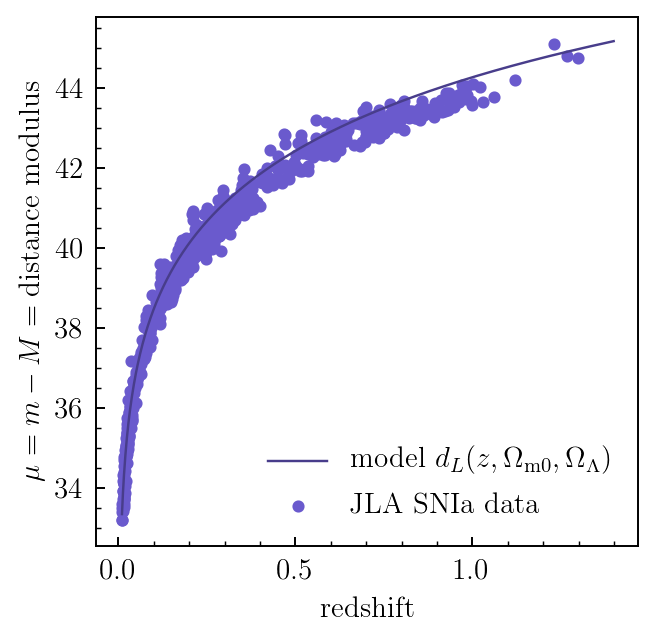

In [12]:
from codes.plot_utils import plot_line_points

plot_line_points(zmodel, mu_model, 
                 xlabel=r'$\rm redshift$', ylabel = r'$\mu=m-M=\rm distance\ modulus$',
                 xp=zCMB, yp=mu_snIa, legend=r'${\rm model}\ d_L(z,\Omega_{\rm m0},\Omega_\Lambda)$', 
                 plegend=r'$\rm JLA\ SNIa\ data$', points=True, figsize=4)

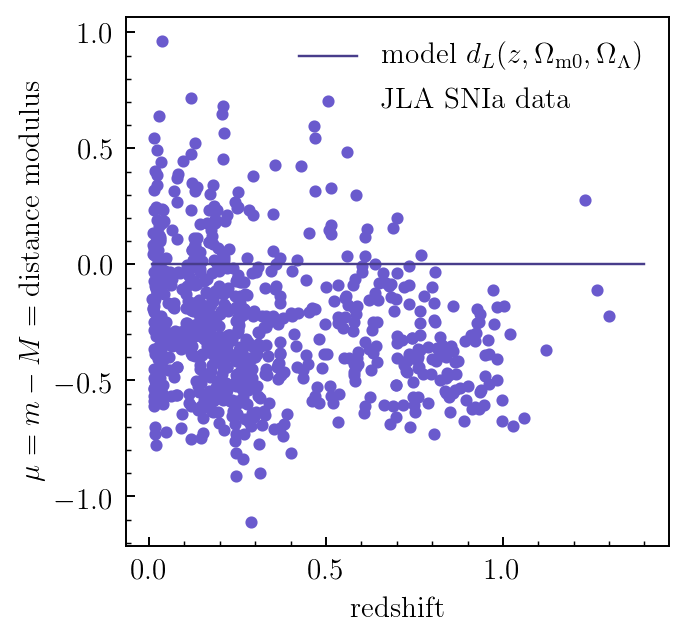

In [13]:
dLmodelzd = d_L_astropy(zCMB, H0, Om0, OmL)
mu_modelzd = 5.0 * np.log10(dLmodelzd) + 25.0 

plot_line_points(zmodel, np.zeros_like(mu_model), 
                 xlabel=r'$\rm redshift$', ylabel = r'$\mu=m-M=\rm distance\ modulus$',
                 xp=zCMB, yp=mu_snIa-mu_modelzd, legend=r'${\rm model}\ d_L(z,\Omega_{\rm m0},\Omega_\Lambda)$', 
                 plegend=r'$\rm JLA\ SNIa\ data$', legendloc='upper right', points=True, figsize=4)

### Is the model a good approximation of the data?

Yes, it's reasonably good (whatever "reasonably" means). 

### How do we know that this is the best possible model representation? 

We don't. To find the best possible representation, we need to scan all of the parameters of $d_L$ (i.e., $H_0$ or $M_0$, $\Omega_{\rm m0}$, $\Omega_\Lambda$) and then find the combination that describes (fits) data best, according to some objective metric. 

Combination of such parameter values is then considered as the "best fit" model parameter values. 

### To scan values of parameters of $d_L$ it would be very useful to be able to compute $d_L$ for all SN redshifts at the same time

Astropy routine allows this (it can handle input vector z, as code below demonstrates): 

In [14]:
tstart = timeit.default_timer()
dLsn_apy = d_L_astropy(zCMB, H0, Om0, OmL)
print("AstroPy execution time = %.2g sec"%(timeit.default_timer()-tstart))

AstroPy execution time = 0.00099 sec


but our distance routine was not set up to handle vector $z$: 

In [15]:
dLsn_our = d_L_romberg(zCMB, H0, Om0, OmL)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [16]:
dLromberg = np.empty_like(zCMB)

import timeit
tstart = timeit.default_timer()
for i, zd in enumerate(zCMB):
    dLromberg[i] = d_L_romberg(zd, H0, Om0, OmL, atol=2.e-16, rtol=2.e-16)
print("scalar d_L Romberg execution time = %.2g sec"%(timeit.default_timer()-tstart))

scalar d_L Romberg execution time = 0.22 sec


This can be fixed by "vectorizing" our routine using <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.vectorize.html">numpy.vectorize</a> routine, as done in the <tt>d_L_vectorized</tt> routine

In [18]:
from codes.cosmology import d_L_vectorized

tstart = timeit.default_timer()
dLsn_our = d_L_vectorized(zCMB, H0, Om0, OmL, atol=2.5e-16, rtol=2.5e-16)
print("vectorized Romberg execution time = %.2g sec"%(timeit.default_timer()-tstart))

vectorized Romberg execution time = 0.18 sec


In [23]:
nOm0 = 100; nOmL = 100 # construct grids of Om0 and OmL values
Om0min, Om0max = 0., 1
Om0g = np.linspace(Om0min, Om0max, nOm0)
OmLmin, OmLmax = 0., 1
OmLg = np.linspace(OmLmin, OmLmax, nOmL)

chi2 = np.empty((nOm0, nOmL))

H0 = 70.
chi2fact = 1.0 / (np.size(zCMB) - 2) # factor for reduced chi^2 = 1/(Nobservations-Nmodelparameters)
tstart = timeit.default_timer()
for i, Omd in enumerate(Om0g):
    for j, Omld in enumerate(OmLg):
            #dL_model = d_L_vectorized(zCMB, H0, Omd, Omld)
            dL_model = d_L_astropy(zCMB, H0, Omd, Omld)
            mu_model =  5.0*np.log10(dL_model) + 25.
            # "reduced chi^2 estimate"
            chi2[i,j] = np.sum(((mu_snIa - mu_model)/emB)**2) * chi2fact
            
print("execution time = %.8g sec"%(timeit.default_timer()-tstart))


execution time = 8.0058516 sec


In [24]:
# find indices of the array that correspond to its minimum value
imin, jmin = np.unravel_index(np.argmin(chi2, axis=None), chi2.shape) 
# and corresponding "best fit" parameters
Om0best = Om0g[imin]; OmLbest = OmLg[jmin]
print("best fit values: Om0 = %.3f  OmL = %.3f"%(Om0best, OmLbest))

best fit values: Om0 = 0.374  OmL = 0.323


In [25]:
zmin = np.min(zCMB); zmax = np.max(zCMB) + 0.1 # max is matched to the extent of the obs. sample
nz = 1000
zmodel = np.linspace(zmin, zmax, nz)

H0, Om0, OmL = 70., Om0best, OmLbest

dLmodel = d_L_astropy(zmodel, H0, Om0, OmL)

mu_model = 5.0 * np.log10(dLmodel) + 25.0 

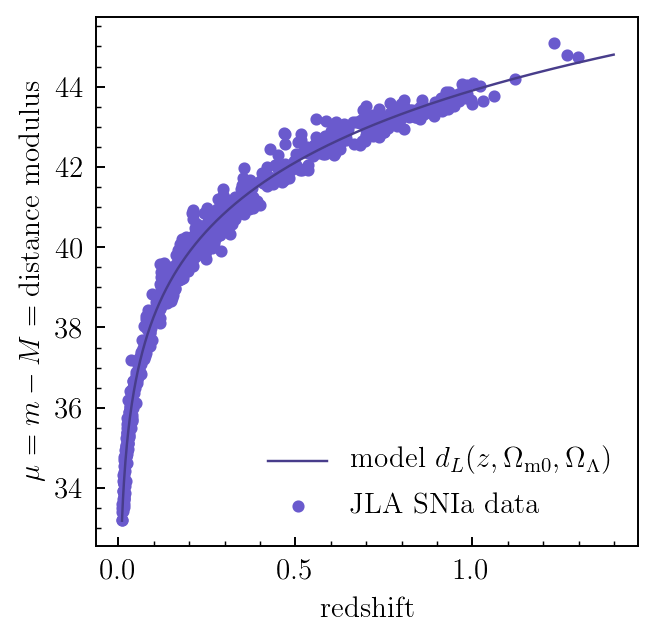

In [26]:
from codes.plot_utils import plot_line_points

plot_line_points(zmodel, mu_model, 
                 xlabel=r'$\rm redshift$', ylabel = r'$\mu=m-M=\rm distance\ modulus$',
                 xp=zCMB, yp=mu_snIa, legend=r'${\rm model}\ d_L(z,\Omega_{\rm m0},\Omega_\Lambda)$', 
                 plegend=r'$\rm JLA\ SNIa\ data$', points=True, figsize=4)

### We need to vary all three parameters, $H_0$ (or $M_0$), $\Omega_\Lambda$, $\Omega_{\rm m0}$ *together*

However, this becomes expensive even with the Astropy routine (calculation of a grid of $100\times 100\times 100=10^6$  values for $H_0$, $\Omega_0$, $\Omega_\Lambda$ would take 10-15 minutes on my laptop). 

This is feasible to do, if needed, but does become somewhat uncomfortably long. 

In practice, it turns out that to do this problem properly more than 3 parameters need to be scanned simulatenously, but more like 5 to 7, because supernovae are not perfect standard candles, but can be standardized with at least two additional parameters. 

You get the idea that in practice the speed of the Astropy routine will not be sufficient to do this in such brute-force scanning manner. We need a faster way to calculate distances, and a smarter (more efficient) way to scan for the best fit parameters. 

The former is achieved using ***function approximation*** techniques, while the latter is handled using the ***optimization*** methods. 

### Computing $d_L(z,H_0,\Omega_{\rm m0},\Omega_\Lambda)$ for a grid of values of $\Omega_{\rm m0}$ and $\Omega_\Lambda$

Here I will use my routine based on the Romberg integration instead of Astropy's routine. 

The reason is that Astropy uses scipy.integrate.quad routine with its default error threshold of $5\times 10^{-8}$ and does not allow users to change the input threshold. In the tests below I am interested to explore accuracy of $d_L$ approximations that are much better than this (down to machine precision) and therefore I need a routine that allows me to compute $d_L$ to machine precision, which our routine allows. 

If we use it to tabulate a grid of $d_L$ values for a single $z$ value instead of the vector, the execution time is manageable. 

In [28]:
nOm0 = 100; nOmL = 100 # construct grids of Om0 and OmL values
Om0min, Om0max = 0., 1
Om0 = np.linspace(Om0min, Om0max, nOm0)
OmLmin, OmLmax = 0., 1
OmL = np.linspace(OmLmin, OmLmax, nOmL)

atol = 5.e-16; rtol = 5.e-16

dLgrid = np.zeros((nOm0, nOmL))
z = 1.0
tstart = timeit.default_timer()
for i, Omd in enumerate(Om0):
    for j, Omld in enumerate(OmL):
            dLgrid[i,j] = d_L_vectorized(z, H0, Omd, Omld, atol=atol, rtol=rtol)
            
print("execution time = %.8g sec"%(timeit.default_timer()-tstart))


execution time = 5.2820946 sec


In [251]:
from matplotlib import cm

def plot_color_map(x, y, data, xlim=[0.,1], ylim=[0.,1.], 
                   xlabel = ' ', ylabel = ' ', cmap='winter', figsize=3.0, figsave=None):
    fig, ax = plt.subplots(figsize=(figsize,figsize))
    ax.axis([xlim[0], xlim[1], ylim[0], ylim[1]])

    plt.xlabel(xlabel); plt.ylabel(ylabel)
    cmap = cm.get_cmap(cmap)
    ax.pcolormesh(x, y, data, cmap=cmap, rasterized=True)
    if figsave:
        plt.savefig(figsave, bbox_inches='tight')

    plt.show()


To learn more about different ways to make color maps in Matplotlib and how to add colorbar to the plot, see <a href="https://matplotlib.org/2.0.1/examples/pylab_examples/pcolor_demo.html">here</a>. 

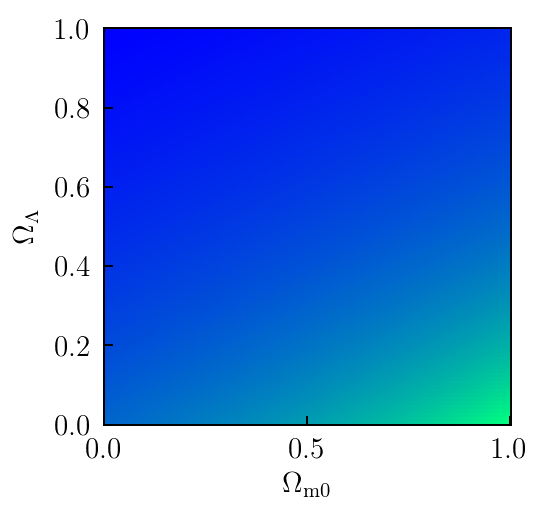

In [252]:
plot_color_map(Om0, OmL, dLgrid, xlim=[0.0,1.001], ylim=[0.,1.0], 
               xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$\Omega_\Lambda$', 
               figsize=3.0)

$\rightarrow$ Dependence of $d_L$ on $\Omega_{\rm m0}$ and $\Omega_\Lambda$ is *very smooth*.

### Approximating functions

Approximating a function that is represented by a finite number of discrete tabulated values or measurements. In each case, there is some uncertainty associated with function values: by *tabulated values* we mean function values computed as accurately as *machine precision* allows. By measurements we mean values of function measured in some way with associated uncertainties usually much larger than the accuracy that is allowed by machine precision. 

### Approximating $d_L$ for faster execution

#### General approach:

1. Define ***training*** and ***test*** sets of parameter values of the approximated function. 
Evaluate function at the parameter values in the training and test sets. 

2. Choose an easier to compute function to approximate the actual (computationally expensive) function.

3. Use the function values calculated for the training set of parameter values in step 1 to calculate parameters of the approximating function.

4. *Test* the accuracy of the approximation by comparing values of the approximating function at the values of parameters in the test set with the values of the approximated function for these parameters. 

### The choice we have already used for function approximation

*Piecewise-linear* approximation using in the trapezoidal integration scheme. 

In [45]:
atol = 2.5e-16; rtol = 2.5e-16 # tabulate d_L to machine precision

OmLd = OmL[10] # select tabulated index of specific Omega_Lambda value
ntr = 15 # number of the training set points
Om0tr = np.linspace(0., 1., ntr)

dLtr = np.empty_like(Om0tr)

for i, Omd in enumerate(Om0tr):
    dLtr[i] = d_L_vectorized(z, H0, Omd, OmLd , atol=atol, rtol=rtol)
    


In [64]:
ntest = 1000 # number of the training set points
Om0test = np.linspace(0., 1., ntest)

dLtest = np.empty_like(Om0test)
for i, Omd in enumerate(Om0test):
    dLtest[i] = d_L_vectorized(z, H0, Omd, OmLd , atol=atol, rtol=rtol)
    
dLpwlin = np.interp(Om0test, Om0tr, dLtr)

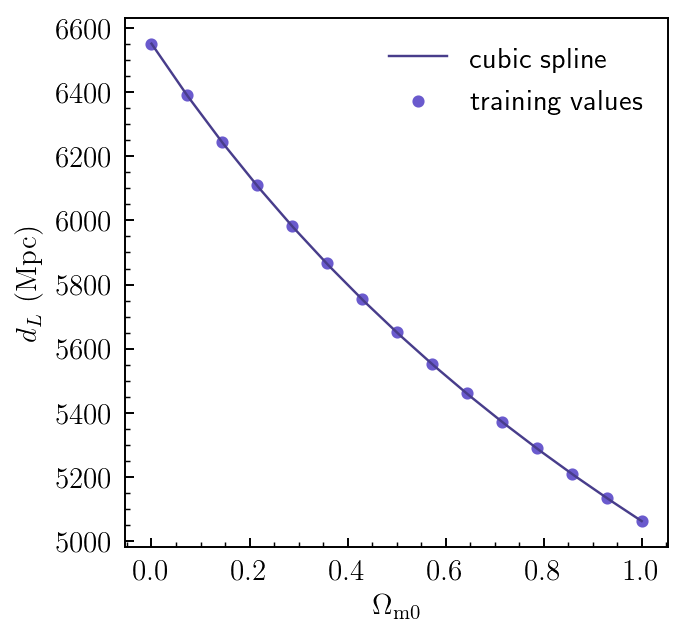

In [65]:
plot_line_points(Om0test, dLpwlin, xp=Om0tr, yp=dLtr, points=True,
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$d_L\rm\ (Mpc)$', 
                 legend='cubic spline', plegend='training values',
                 legendloc='upper right', figsize=4)

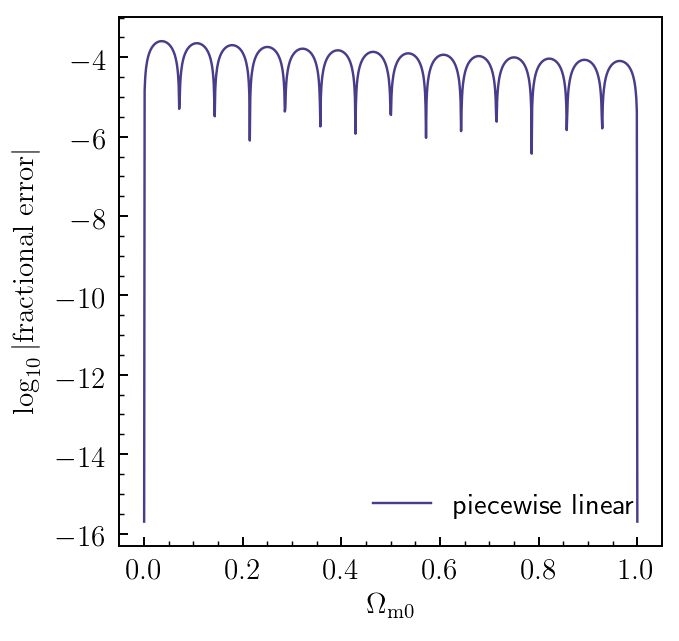

In [66]:
plot_line_points(Om0test, np.log10(np.maximum(2.e-16,np.abs(1.-dLpwlin/dLtest))), 
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$\log_{10}\vert\rm fractional\ error\vert$', 
                 legend='piecewise linear', plegend='training values',
                 legendloc='lower right', figsize=4)

### Piecewise spline interpolation

Piecewise spline interpolation uses specially constrained local polynomials called *splines* to approximate the function segment by segment. 

*The constraints are designed to ensure smooth change of the first derivatives of the spline across interpolation interval and thus smooth behavior of the interpolating function.* 

Splines of high order can be constructed, in principle, if we have enough tabulated points. However, higher order splines need more constraints to determine the coefficients and are also subject to stronger oscillations for equidistant points as any higher order polynomial. 

In practice, *cubic splines* are most popular, because they give high order of accuracy, while being sufficiently low order to avoid oscillations. 

### Cubic Splines

For a set of $N+1$ points $\{x_i\}$ and corresponding tabulated function values $\{\tilde{f}_i\}$, we define splines for each of $N$ intervals $i$, $[x_i,x_{i+1}]$, as a third order polynomial:

$$
s_i(x) = a_i + b_i(x-x_i) + c_i(x-x_i)^2 + d_i(x-x_i)^3.
$$

with the following constraints: 

* $s_i(x_i) = \tilde{f}_i,$ $\rightarrow N$ constraints;

* $s_i(x_{i+1})=\tilde{f}_{i+1}$, $\rightarrow N$ constraints;  

* $s^{\prime}_i(x_{i+1})=s^\prime_{i+1}(x_{i+1}),$ $\rightarrow N-1$ constraints;

* $s^{\prime\prime}_i(x_{i+1})=s^{\prime\prime}_{i+1}(x_{i+1}),$ $\rightarrow N-1$ constraints. 

We thus have $4N-2$ constraints, but we need to determine $4N$ coefficients. Two additional constraints are chosen for the edge points of the interpolating polynomial, $x_0$ and $x_N$. Different choices of such edge constraints result in spline interpolations of different type. 


### Types of Cubic Splines

* *Natural spline:* $s_0^{\prime\prime}(x_0)=0$ and $s^{\prime\prime}_{N-1}(x_N)=0$. 


* *Curvature-adjusted spline:* $s_0^{\prime\prime}(x_0)=v_0$ and $s^{\prime\prime}_{N-1}(x_N)=v_{N-1}$, where $v_0$ and $v_{N-1}$ are specified constants. 


* *Clamped spline:*  $s_0^{\prime}(x_0)=u_0$ and $s^{\prime}_{N-1}(x_N)=u_{N-1}$, where $u_0$ and $u_{N-1}$ are specified constants. 



* *Parabolically terminated spline:*  $d_0=d_{N-1}=0$. 


* *Not-a-knot spline:*  do not use $x_1$ and $x_{N-1}$ as knots of the spline (these two points are then *not knots*, hence the name), which reduces the number of spline intervals by two from $N$ to $N-2$. The tabulated function values $f_1$, $f_{N-1}$ are still used for determination of coefficients. The total number of unknowns now is $4(N-2)$, while tabulated function values provide $N+1$ constraints and conditions of continuity of the spline and its first two derivatives at the inner (not boundary) $(N-3)$ knots adds $3(N-3)$ constraints for the total of $4N-8$ constraints. Thus, we can compute spline coefficients without assuming  any other conditions. 


Natural cubic spline is most commonly used type in practice, because generally we have limited information about interpolated function or its derivatives. 

### Linear system of equations for spline coefficients
---------------------------------
*This is a technical info on derivation of the equations for spline coefficients. You can skip it, unless you are curious about how splines are constructed in detail.*

---------------------------------

For a set of $N$ cubic splines defined for $N+1$ interpolation points $\{x_i\}$ and corresponding function values $f_i$:

$$
s_i(x) = a_i + b_i(x-x_i) + c_i(x-x_i)^2 + d_i(x-x_i)^3,
$$

with $4N$ constraints discussed above, we can compute $4N$ coefficients $\{a_i,b_i,c_i,d_i\}$. 
Derivation presented here uses *natural spline* edge constraints. Similar systems of equations are derived for other types of splines. 

Spline constraint $s^{\prime\prime}_i(x_{i+1})=s^{\prime\prime}_{i+1}(x_{i+1})$ results in equation
$$
s^{\prime\prime}_i(x_{i+1})-s^{\prime\prime}_{i+1}(x_{i+1})=0= 2(c_i-c_{i+1} )+6d_i\delta_i,\ \ \ \rightarrow d_i = \frac{c_{i+1}-c_i}{3\delta_i},\ \ \ (1)
$$
where $\delta_i=x_{i+1}-x_i$. 

Condition $s_i(x_{i+1})=s_{i+1}(x_{i+1})$ gives

$$
f_i+b_i \delta_i+c_i\delta_i^2 + d_i \delta_i^3 = f_{i+1},
$$

which gives (denoting $\Delta_i=f_{i+1}-f_i$)

$$
 b_i=\frac{\Delta_i}{\delta_i} - c_i\delta_i - d_i\delta_i^2=\frac{\Delta_i}{\delta_i} - (c_{i+1}+2c_i)\frac{\delta_i}{3},\ \ \ \ (2)
$$

where  equation 1 was used for $d_i$. 

The third spline condition, $s^\prime_i(x_{i+1})=s^\prime_{i+1}(x_{i+1})$, gives equations: 
$$
s^\prime_i(x_{i+1})-s^\prime_{i+1}(x_{i+1}) = 0 = b_i-b_{i+1} + 2c_i\delta_i + 3d_i\delta_i^2.
$$

Substituting eqsuations 1 and 2 into this equation, after a bit of algebra we can get: 
$$
\delta_i c_i + 2(\delta_i+\delta_{i+1})\,c_{i+1} + \delta_{i+1}c_{i+2} = 3\left(\frac{\Delta_{i+1}}{\delta_{i+1}}-\frac{\Delta_i}{\delta_i}\right),\ \ \ \ i=0,\dots, N-2.
$$

Given that $c_{i+2}$ is needed in this equation, it can only be defined for the first $N-1$ intervals and for the $(N-1)$-th interval $c_{i+2}=c_{N-1}=s^{\prime\prime}_{N-1}(x_N)/2$. 

For natual splines $s^{\prime\prime}_{0}(x_0)=s^{\prime\prime}_{N-1}(x_N) = 0$, i.e. $c_0=c_{N-1}=0$, which provide 2 additional equations to derive $N$ constants $\{c_i\}$, $i=0,\dots, N-1$. The system of linear equations for $c_i$ can be 
written in matrix form: 
\begin{equation}
\begin{bmatrix} 
1 & 0 & 0 & \cdots &  & & \\
\delta_0 & 2(\delta_0+\delta_1) & \delta_1 & \ddots & & & \\
0             &  \delta_1  & 2(\delta_1+\delta_2) & \delta_2 & \ddots & & \\
    & \ddots & \ddots & \ddots & \ddots & & \\
              &            &             &             &\delta_{N-2} &2(\delta_{N-2}+\delta_{N-1}) &\delta_{N-1} \\
              &            &             &             & 0  & 0 & 1
\end{bmatrix}
\left[ \begin{array}{c} c_0\\ c_1\\ \vdots\\ \vdots\\ \vdots \\ c_{N-1} \end{array} \right] 
=
\left[ \begin{array}{c} 0\\ 3\left(\frac{\Delta_1}{\delta_1}-\frac{\Delta_0}{\delta_0}\right)\\ \vdots\\ \vdots\\  
3\left(\frac{\Delta_{N-1}}{\delta_{N-1}}-\frac{\Delta_{N-2}}{\delta_{N-2}}\right)\\ 0 \end{array} \right] 
\end{equation}

Note that constraints mostly relate neighboring three intervals. This is why the left matrix is tridiagonal and such matrix equation can be solved efficiently using the <a href="https://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)">Thomas method</a>. This method solves such system of equations in $\sim \mathcal{O}(N)$ operations. 

Once $\{c_i\}$ are obtained as a solution of the above matrix equation,  $\{b_i\}$ and  $\{d_i\}$ coefficients can be computed   
using equations 2 and 1.

In [29]:
def cubic_spline_coefficients_simple(xi, fi):
    """
    straightforward programming of the spline coefficient computation without using vectorized ops
    for input training set values vectors xi and fi
    linear system of equation is solved inefficiently without taking into account that matrix A is tridiagonal
    
    Returns: 
        coefficients vectors a, b, c, d of the cubic spline interpolating xi, fi
                dx = x - xi[i]
                fx = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)
    """
    nx = np.size(xi)
    for i in range(1, nx-1):
        delx[i] = xi[i+1] - xi[i]
        delf[i] = fi[i+1] - fi[i]

    # form matrices to solve for spline coefficients
    vx = np.zeros_like(xi)
    A = np.zeros((nx,nx))
    A[0,0] = 1.; A[nx-1,nx-1] = 1.
    for i in range(1, nx-1):
        delx[i] = xi[i+1] - xi[i]
        delf[i] = fi[i+1] - fi[i]
        vx[i] = 3*(delf[i]/delx[i] - delf[i-1]/delx[i-1])
        A[i,i] = 2.*(delx[i-1] + delx[i])
        A[i,i-1] = delx[i-1]
        A[i,i+1] = delx[i]
        
    # solve for c coefficients inefficiently
    c = np.linalg.solve(A,vx)
    b = np.zeros(nx-1); d = np.zeros(nx-1)
    for i in range(nx-1):
        b[i] = delf[i]/delx[i] - (c[i+1] + 2.*c[i])*delx[i]/3.
        d[i] = (c[i+1] - c[i])/(3.*delx[i]) 
    a = fi
    return a, b, c, d   

In [30]:
def cubic_spline_coefficients(xi, fi):
    """
    compute coefficients of the interpolating natural cubic spline
    see Appendix in the note for the derivation and details of the algorithm
    
    Parameters: 
        xi, fi: numpy float vectors
                tabulated points and function values
            
    Returns:
        a, b, c, d: numpy float vectors
                cubic spline coefficients 
                dx = x - xi[i]
                fx = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)

    """
    delx = np.diff(xi); delf = np.diff(fi)
    # form matrices to solve for spline coefficients
    vx = np.zeros_like(xi)
    # form rhs vector using python's array slicing 
    vx[1:-1:] = 3.*(delf[1::]/delx[1::] - delf[:-1:]/delx[:-1:])
    # construct 3 diagonals
    nx = np.size(xi)
    diags = np.zeros((3, nx))
    diags[1,0] = 1.; diags[1,-1] = 1.
    diags[1,1:-1:] = 2. * (delx[1::] + delx[:-1:])
    diags[0,1:] = delx[:]
    diags[2,1:-1] = delx[1:]
    # solve for coefficients c using Thomas algorithm for tri-diagonal matrices
    # see https://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
    ac, bc, cc, dc = map(np.array, (diags[0,:], diags[1,:], diags[2,:], vx)) # copy arrays
    for k in range(1, nx):
        mk = ac[k] / bc[k-1]
        bc[k] = bc[k] - mk * cc[k-1] 
        dc[k] = dc[k] - mk * dc[k-1]
    
    c = np.zeros_like(bc)
    c[-1] = dc[-1] / bc[-1]

    for k in range(nx-2, -1, -1):
        c[k] = (dc[k]-cc[k]*c[k+1])/bc[k]

    # now get the rest of the coefficients
    b = delf[::]/delx[::] - (c[1::] + 2.*c[:-1:])*delx[::]/3.
    d = (c[1::] - c[:-1:])/(3.*delx[::]) 
    a = fi
    return a, b, c, d

In [33]:
def cubic_spline_scalar(x, xi, a, b, c, d):
    """
    piecewise linear approximation of f(x) given input of tabulated values of xi and fi
    note that xi are expected in ascending order
    
    Returns:
        vector of spline values at test points x and a vector of spline derivatives

    """
    n = np.size(xi) - 1
    for i in range(n):
        if (x >= xi[i]) and (x <= xi[i+1]):
            # reusing computations is always a good idea, but here we also can return dfdx
            dx = x - xi[i]
            fx = a[i] + dx*(b[i] + c[i]*dx + d[i]*dx*dx)
            dfdx = b[i] + dx * (2.*c[i] + 3.*d[i]*dx)
            return fx, dfdx

In [67]:
a, b, c, d = cubic_spline_coefficients(Om0tr, dLtr)

dLspt= np.empty_like(Om0test)

for i, Omd in enumerate(Om0test):
    dLspt[i], dummy = cubic_spline_scalar(Omd, Om0tr, a, b, c, d)

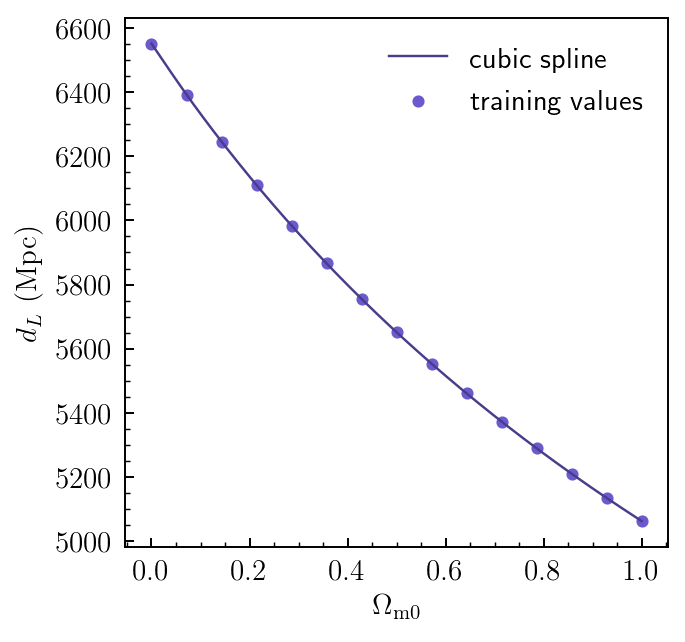

In [68]:
plot_line_points(Om0test, dLspt, xp=Om0tr, yp=dLtr, points=True,
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$d_L\rm\ (Mpc)$', 
                 legend='cubic spline', plegend='training values',
                 legendloc='upper right', figsize=4)

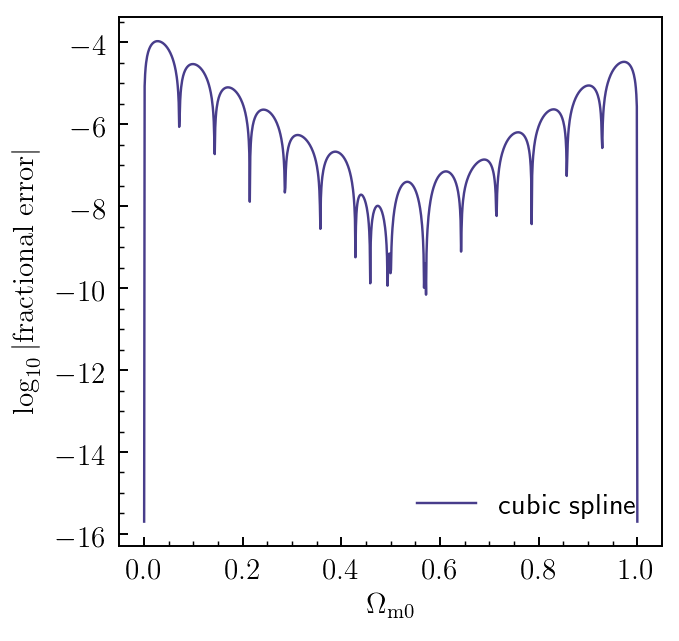

In [69]:
plot_line_points(Om0test, np.log10(np.maximum(2.e-16,np.abs(1.-dLspt/dLtest))), 
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$\log_{10}\vert\rm fractional\ error\vert$', 
                 legend='cubic spline', plegend='training values',
                 legendloc='lower right', figsize=4)

### Approximating $d_L(\Omega_{\rm m0})$ using polynomial expansion

denoting $x=\Omega_{\rm m0}$ for convenience: 

$$d_L = \sum\limits_{i=0}^{p}a_i x^i = a_0 + a_1 x + a_2 x^2 +\ldots + a_p x^p
$$

### Approximation by a polynomial is a special case of approximation via basis expansion 

$$f(x)\approx \sum\limits_{k=0}^m a_k\psi_k(x),$$

where $a_k$ are some coefficients to be determined and are sometimes called *components* of $f(x)$. 

The basis functions $\psi_k$ must be *linearly independent*, which means that the sum $\sum_{k=0}^m a_k\psi_k(x)=0$ for any $x$ only when $a_k=0$ for all $k$. The linear independence requirement is to ensure that general $f(x)\ne 0$ can be represented by the sum.

For example, one can think of piecewise approximation of the function as such expansion, where approximation in each of the interval $[x_i,x_{i+1})$ corresponds to one term in the above expansion. This is similar to how areas of trapezoids in trapezoidal integration are summed to calculate the total integral estimate. 

If we have a training set of $N+1$ function values, $f_i=d_L(x_i)$, at points $\{x_i\}$ ($i=0,\dots,N$) allow construction of approximating polynomial $P_N(x)$ of the order $p\leq N$ (2 points allow linear interpolation, 3 points -- quadratic, etc.). 

* **Interpolation:** $p=N$ and we require approximating function to match each training set value $f_i$ to machine precision. 

The problem is fully determined  because we have $N+1$ tabulated training values, $f_i$, to constrain $N+1$ polynomial coefficients. This can be done by solving the system of equations using some method. 

* **Regression:** $p\leq N$ and we do not require approximating function to match any of the training $f_i$ values. 

In this case, coefficients are determined using a set of conditions. The most common choice is to use the condition that coefficients minimize the following sum of squares: 
$$E_2 = \sum\limits_{i=0}^{N}w(x_i)\left[f_i - \sum\limits_{k=0}^m a_k\psi_k(x_i)\right]^2,
$$
where $w(x)\geq 0$ is a weight function, which can allow us to give larger or smaller weight to certain values of $x$. Note that weights for different $x_i$ are assumed to be independent of each other here.

### Interpolation with a global polynomial. 

The system of equations 

\begin{eqnarray}
f_{0} &=&  a_0 + a_1 x_0 + a_2 x^2_0 +\ldots + a_N x^N_0\\
f_{1} &=&  a_0 + a_1 x_1 + a_2 x^2_1 +\ldots + a_N x^N_1\\
\ldots & & \ldots\\
f_{N} &=&  a_0 + a_1 x_N + a_2 x^2_N +\ldots + a_N x^N_N\\
\end{eqnarray}

We can think of the set of $f_i$ and $a_i$ values as forming vectors $\mathbf{f}$ and $\mathbf{a}$ and the system of equations can be written in matrix form as: $\mathbf{f}=\mathbf{V}\mathbf{a}$, where  $\mathbf{V}$ is called the Vandermode matrix after French mathematician <a href="https://en.wikipedia.org/wiki/Alexandre-Th%C3%A9ophile_Vandermonde">Alexandre-Théophile Vandermonde</a> (1735-1796).


$$
\mathbf{V}=
\begin{bmatrix}
1 & x_0 & x_0^2 & \ldots & x_0^N \\
1 & x_1 & x_1^2 & \ldots & x_1^N \\
\vdots & & \ddots & & \vdots\\
1 & x_N & x_N^2& \dots& x_N^N 
\end{bmatrix}
$$

### Solution of the system of equation

can be formally written in the vector form as $\mathbf{a} = \mathbf{V}^{-1}\mathbf{f}$. 

In [570]:
atol = 2.5e-16; rtol = 2.5e-16 # tabulate d_L to machine precision

OmLd = OmL[10] # select tabulated index of specific Omega_Lambda value
ntr = 15 # number of the training set points
Om0tr = np.linspace(0., 1., ntr)

dLtr = np.empty_like(Om0tr)

for i, Omd in enumerate(Om0tr):
    dLtr[i] = d_L_vectorized(z, H0, Omd, OmLd , atol=atol, rtol=rtol)

Numpy has a routine <a href="https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.vander.html">numpy.vander</a> that facilitates formation of the matrix $\mathbf{V}$.

In [571]:
V = np.vander(Om0tr, N=ntr, increasing=True) # set up the Vandermonde matrix

a = np.dot(np.linalg.inv(V), dLtr) # a = V^{-1} f
# object for polynomial with coefficients a 
# [::-1] reverses order of the coefficients, as requiered by this routine
pfit = np.poly1d(a[::-1]) 

In [572]:
ntest = 100 # number of the training set points
Om0test = np.linspace(0., 1., ntest)
dLtest = np.empty_like(Om0test)
for i, Omd in enumerate(Om0test):
    dLtest[i] = d_L_vectorized(z, H0, Omd, OmLd , atol=atol, rtol=rtol)
    
dLpoly = pfit(Om0test)

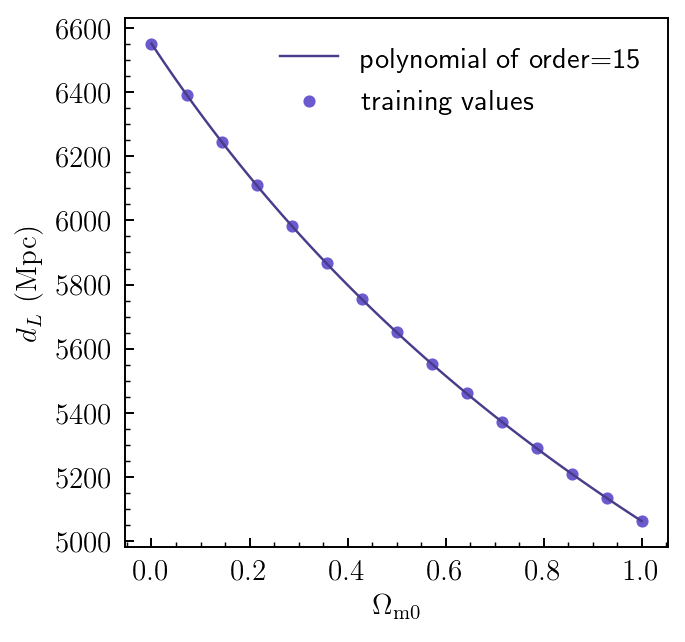

In [573]:
plot_line_points(Om0test, dLpoly, xp=Om0tr, yp=dLtr, points=True,
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$d_L\rm\ (Mpc)$', 
                 legend='polynomial of order=%d'%ntr, plegend='training values',
                 legendloc='upper right', figsize=4)

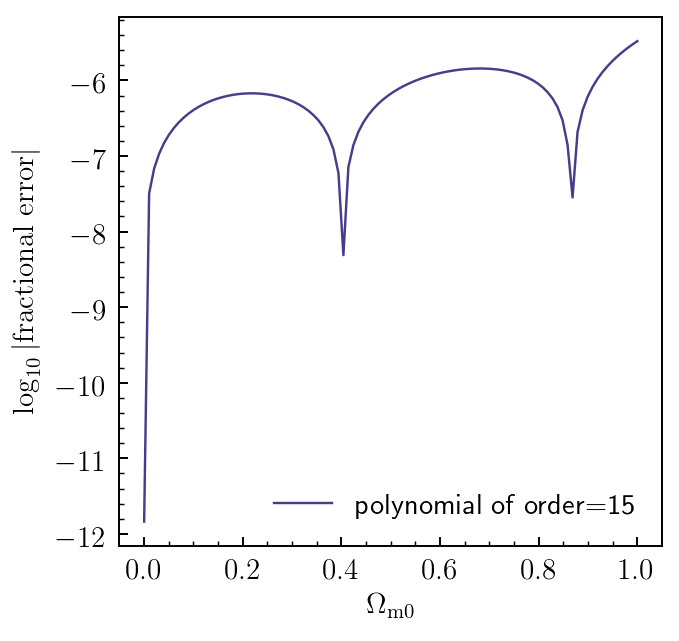

In [574]:
plot_line_points(Om0test, np.log10(np.maximum(np.abs(1.-dLpoly/dLtest), np.abs(dLpoly)/2**52)),
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$\log_{10}\vert\rm fractional\ error\vert$', 
                 legend='polynomial of order=%d'%ntr, plegend='training values',
                 legendloc='lower right', figsize=4)

This looks quite simple, but in practice this is often not so simple because: 1) matrix inversion in general requires $\mathcal{O}(N^\mu)$ operations where $\mu\approx 2.4-3$ depending on the matrix and inversion algorithm used, so when $N=1000$, $\mathcal{O}(10^8-10^9)$ operations is required, and 2) entries of $\mathbf{V}$ can span a wide range, and many rows of it can be close to zero, which makes $V$ ill-conditioned and can make inversion process numerically inaccurate or even unstable due to roundoff errors arising from operating (multiplying and summing) numbers of vastly different magnitude. 

Thus, *applications of such simple linear algebra approach is limited to small $N$.* You can see this for yourself by changing value of <tt>ntr</tt> above beyond 20 and seeing how calculaton becomes numerically unstable. 

### The origin of unstable behavior 

is in the numerical difficulties in computing inverse matrix. Some entries of $\mathbf{V}$ can be very small, while calculations with their inverse are done in computing $\mathbf{V}^{-1}$. 

This is yet another manifestation of the significant difference between mathematics and numerical computation!

A square matrix $\mathbf{A}$ is called *ill-conditioned*, if it has large *condition*, defined as $\mathrm{cond}(\mathbf{A})=\lVert\mathbf{A}\rVert\,\lVert \mathbf{A}^{-1}\rVert$.  

Here $\lVert\mathbf{A}\rVert =\max_i \Sigma_j \vert A_{ij}\vert$ is the norm of the matrix, or the largest  among the sums of absolute values of the row elements of the matrix. 

$\mathrm{cond}(\mathbf{A})$ is the largest error magnification factor due to numerical errors during calculations, such as computing its inverse. 




In [575]:
# condition of the Vandermonde matrix 
print(np.linalg.cond(V))

403234828636.11945


### To avoid this in practice

* Interpolation is done *using different polynomial basis.* 


* When matrix inversion is needed during regression it is done using much more stable and more efficient methods, based on the QR decomposition and the Singular Value Decomposition (SVD). 

First, we are not limited to expressing polynomial of order $N$ using the *monomials* $x^k$: 
\begin{equation}
P_N(x)= \sum\limits_{k=0}^{N}a_k x^k.
\end{equation}
For example, a quadratic polynomial $7-5x+x^2$ can be written  as $1+2(x-3)+(x-3)(x-4)$, which is called *the Newton form*.


We can generally express a polynomial of order $\leq N$ as: 
\begin{equation}
P_N(x)= \sum\limits_{k=0}^{N}a_k \pi_k(x),
\end{equation}
where $\pi_k(x)$ is a polynomial of order $k$ expressed in some form. Clearly, the choice of $\pi_k(x)$ will determine the form of the Vandermonde matrix and thus its inverse.

The two most commonly chosen forms for $\pi_k(x)$ are the Newton and Lagrange forms. In the former case the polynomial is computed using *method of divided differences*, while in the former *barycentric interpolation method* is used to compute interpolating polynomial. 

### Polynomials in the Newton form.

We can express polynomial of order $N$ in the *Newton form* with $\pi_0=1$, $\pi_1(x)=x-x_0$ and $\pi_k(x)=\prod_{j=1}^{k-1}(x-x_j)$, i.e.:
\begin{eqnarray}
p_N(x)&=&a_0 + a_1(x-x_0) + a_2(x-x_0)(x-x_1) +\ldots + a_N(x-x_0)\ldots (x-x_{N-1})\nonumber\\
         &=&a_0 + \sum\limits_{k=1}^N a_k\prod\limits_{j=0}^{k-1}(x-x_j).
\end{eqnarray}
Here and below $\prod_{j=0}^{k-1}$ stands for "product of terms from $0$ to $k-1$." 

It can be easily seen that the Vandermonde matrix in this case has non-zero entries only on the diagonal and below as
\begin{eqnarray}
 f(x_0) &=& a_0,\\
 f(x_1) &=&a_0 + a_1(x_1-x_0),\\
 f(x_2) &=&a_0 + a_1(x_2-x_0) + a_2(x_2-x_0)(x_2-x_1),\\ 
 f(x_N)&=&a_0 + a_1(x_N-x_0) + a_2(x_N-x_0)(x_N-x_1) +\cdots + a_N(x_N-x_0)(x_N-x_1)\cdots (x_N-x_{N-1}).
\end{eqnarray}

 The simplified $L$-form of matrix $\mathbf{V}$ allows its inversion to compute coefficients $a_k$ in $\mathcal{O}(N^2)$. Polynomial in the Newton form can be evaluated for a given $x$ in $2N$ additions plus $N$ multiplications, if the sum in the first equation above is computed using the nested form: 
\begin{equation}
p_N(x)=a_0 + (x-x_0)\left\{a_1+ (x-x_1)\left[a_2 +\ldots + (x-x_{N-2})(a_{N-1} + (x-x_{N-1})a_N)\right]\right\} \label{eq:polynested}
\end{equation}


### Computing Newon polynomial coefficients using divided differences}
 
 In fact, there is an elegant recursive procedure for computing these coefficients. It is easy to see from above that $a_0 = f(x_0)$ and $a_1 = (f_1-f_0)/(x_1-x_0)$. To express the other coefficients, we will use notation of {\it divided differences}, which approximate derivatives of $f(x)$ of different order over the interval of input $x$ values: 
\begin{equation}
f[x_i] = f(x_i);\ \ \rightarrow a_0=f[x_0]; 
\end{equation}
\begin{equation}
f[x_i,x_{i+1}] = \frac{f[x_{i+1}]-f[x_i]}{x_{i+1}-x_i}= \frac{f_{i+1}-f_i}{x_{i+1}-x_i}=\frac{f_i}{x_i-x_{i+1}} +  \frac{f_{i+1}}{x_{i+1}-x_{i}}
\end{equation}
and thus
\begin{equation}
 a_1 = \frac{f(x_1)-f(x_0)}{x_1-x_0} = f[x_0,x_1]
\end{equation}
Similarly, we can define $f[x_i,x_{i+1},x_{i+2}]$ which recursively uses the divided differences defined above: 
\begin{eqnarray}
f[x_i,x_{i+1},x_{i+2}] &=& \frac{f[x_{i+1},x_{i+2}]-f[x_{i},x_{i+1}]}{x_{i+2}-x_i}\nonumber\\
&=& \frac{1}{x_{i+2}-x_i}\,\left[\frac{f_{i+2}-f_{i+1}}{x_{i+2}-x_{i+1}}-\frac{f_{i+1}-f_{i}}{x_{i+1}-x_{i}}\right]\\
&=& \frac{f_i}{(x_i-x_{i+1})(x_i-x_{i+2})} +  \frac{f_{i+1}}{(x_{i+1}-x_{i})(x_{i+1}-x_{i+2})} + \frac{f_{i+2}}{(x_{i+2}-x_{i})(x_{i+2}-x_{i+1})}.\nonumber
\end{eqnarray}
Then, with a bit of algebra we can show that 
\begin{equation}
a_2 = f[x_0,x_1,x_2] 
\end{equation}
and, in general, 
\begin{equation}
f[x_i,\ldots,x_{i+n}]=\frac{f[x_{i+1},\ldots,x_{i+n}]-f[x_i,\ldots,x_{i+n-1}]}{x_{i+n}-x_i}=\sum\limits_{j=0}^n\,\frac{f(x_{i+j})}{\prod_{k=0,k\ne j}^n(x_{i+j}-x_{i+k})}.
\end{equation}
and
\begin{equation}
a_k = f[x_0,x_1,\ldots, x_k].
\end{equation}

The divided differences of any order can thus be constructed progressively from the differences of one order lower. These differences are coefficients in the interpolating polynomial
of function $f(x)$ tabulated at $\{x_i\}_{i=0,N}$:
\begin{eqnarray}
f(x)\approx p_N(x)&=&f[x_0] + f[x_0,x_1](x-x_0) + f[x_0,x_1,x_2](x-x_0)(x-x_1) +\ldots \nonumber\\
         &&+ f[x_0,\ldots,x_N](x-x_0)\ldots (x-x_{N-1}). 
\end{eqnarray}
Note that for equidistant nodes, all differences $x_k-x_m=\Delta x$ are equal. In this case, the polynomial approximation above is essentially the approximate Taylor expansion
around $x_0$ with divided differences representing estimates of the derivatives of different order evaluated at $x_0$ divided by $n!$. These estimates are done in a way that guarantees
that $p_N(x)$ matches $f(x)$ at its tabulated values. 

In [ ]:
def polyint_newton(xi, fi, xt):
    """
    routine to compute 1d interpolating polynomial using Newton's divided differences
    for input training set parameter values, xi and fi, and for input vector of test points xt
    using equations presented above
    
    The routine is not vectorized or optimizied for speed and is presented for illustration purposes
    It is quite useable, however, for practical interpolation for moderate sizes of vectors.
    """
    n = np.size(fi)
    df = np.zeros((n,n))
    # compute divided differences
    df[:,0] = fi 
    for i in range(2,n):
        for j in range(1,n+1-i):
            df[j-1,i-1] = (df[j,i-2] - df[j-1,i-2]) / (xi[j+i-2] - xi[j-1])
    
    # compute intepolating polynomial values at the input test points
    pxt = np.zeros_like(xt)
    pxt = pxt + df[0,0]
    for j, xd in enumerate(xt):
        dx = 1.
        # nested evaluation of the polynomial
        for i in range(1,n):
            dx *= (xd - xi[i-1])
            pxt[j] += df[0,i]*dx

    return pxt

### Lagrange representation of interpolating polynomials


The linear interpolating polynomial that was derived from the Taylor expansion formula is a specific instance of the general Lagrange formula for polynomial of order $N$ using $N+1$ interpolation points (or *nodes*):
$$
f(x)\approx L_N(x) = \sum\limits_{i=0}^{N} L_i(x)f(x_i),\ \ {\rm where}\ \ \ L_i(x)=\prod\limits_{j=0,\, j\ne i}^{N}\,\frac{x-x_j}{x_i-x_j}.
$$

If the expression looks strange to you and you doubt that it is indeed a polynomial, you can convince yourself that this is a formula for polynomials by manually unfolding the sum for $N=2, 3, 4$.

It is clear that the expression has the form that guarantees that interpolating polynomial matches every input $f(x=x_i)$ value exactly.
All terms of the order different from $i$ will be zero because they will contain terms proportional to $x_i-x_i$. For the $i$-th order 
term  $L_i(x_i)=1$ and thus $L_N(x_i)=L_i(x_i)f(x_i)=f(x_i)$. 

Thus, $L_j(x_i)=1$ for $i=j$ and $0$ for $i\ne j$.

The computation of the polynomial using the Lagrange formula above requires of order $O(N^2)$ operations (**Q:** do you see why?).

The computations may thus be expensive for large $N$ and coefficients may become large. Summation of a long series of large numbers can be prone to roundoff errors. Thus, it used to be thought that the Lagrange formula is not useful in practice for computing interpolating polynomials. *However,...*

### Modified Lagrange formula
$$
f(x)\approx L_N(x) = \sum\limits_{i=0}^{N} L_i(x)f(x_i),\ \ \mathrm{where}\ \ \ L_i(x)=\prod\limits_{j=0,\, j\ne i}^{N}\,\frac{x-x_j}{x_i-x_j}.
$$

The Lagrange formula above can be re-written in such a way that it can be often evaluated in $O(N)$ operations. 

The $L_i(x)$ can be writted as 

$$L_i(x)=\frac{1}{\prod\limits_{j=0, j\ne i}^{N}\,x_i-x_j}\,\frac{\prod\limits_{j=0}^{N}\,x-x_j}{x-x_i}=\frac{1}{\prod\limits_{j=0, j\ne i}^{N-1}\,x_i-x_j}\,\frac{l(x)}{x-x_i}.$$

If we define the *barycentric weights* by

$$w_i = \frac{1}{\prod\limits_{j=0,\, j\ne i}^{N}(x_i-x_j)},\ \ \ \ i=0,\dots,N$$

So that

$$L_i(x) = l(x)\,\frac{w_i}{x-x_i}.$$

And interpolating polynomial is given by 
$$
L_N(x)=l(x)\sum\limits_{j=0}^{N}\frac{w_j}{x-x_j}\, f_j.
$$

### Barycentric interpolation formula

Lagrange polynomial formula in eq. can be used to approximate any function $f(x)$. If we use for the constant function $f(x)=1$, we have: 

$$
1 = l(x)\sum\limits_{i=0}^{N} f(x_i)\,\frac{w_i}{x-x_i}=l(x)\sum\limits_{i=0}^{N}\,\frac{w_i}{x-x_i}.
$$

$l(x)$ is independent of the function we are interpolating and $i$ and thus if we divide above by the equation for $L_N(x)$: 
$$
L_N(x)=l(x)\sum\limits_{j=0}^{N}\frac{w_j}{x-x_j}\, f_j.
$$
    
$l(x)$ cancels out: 

$$
L_N(x) = \frac{\sum\limits_{i=0}^{N} f(x_i)\,\frac{w_i}{x-x_i}}{\sum\limits_{i=0}^{N} \frac{w_i}{x-x_i}}.
$$
This expression is called *the barycentric interpolation formula.* It's an algebraic recasting of the same equation, but it allows *much* more efficient computation than one would naively expect. 

### Barycentric Lagrange interpolation formula

$$
f(x)\approx L_N(x) = \frac{\sum\limits_{i=0}^{N} f(x_i)\,\frac{w_i}{x-x_i}}{\sum\limits_{i=0}^{N} \frac{w_i}{x-x_i}}.
$$

### Advantages: 

* *barycentric weights*

$$w_i = \frac{1}{\prod\limits_{j=0,\, j\ne i}^{N}(x_i-x_j)},\ \ \ \ i=0,\dots,N$$

do not depend on $f(x)$ and so can be computed once and then used for any function to compute polynomial values in $O(N)$ operations. 


* $w_i$ enter in the numerator and denumenator, so any factor that does not depend on $i$ cancels out and can be left out.

* Close examination of the expression shows that when new interpolation nodes need to be added (inserted), the interpolating polynomial can be recomputed in $O(N)$ operations.

* Finally, for some specific arrangements of interpolation nodes $\{x_i\}$ weights $w_i$ are known analytically. 

### Barycentric interpolation for evenly spaced interpolation nodes 

Consider $N+1$ points on interval $[-1,1]$ equidistant from each other - i.e., separated by  $\Delta x=h=2/N$. 

In this case weights are known analytically: 

$$w_i=\frac{(-1)^{N-i}}{(h^N\,N!)}\,\binom{N}{i},$$

where $\binom{N}{i}$ is <a href="http://mathworld.wolfram.com/BinomialCoefficient.html">the binomial coefficient.</a>  However, $h^N\,N!$ does not depend on $i$, and thus can be dropped as noted above. 

$$
w_i=(-1)^i\binom{N}{i}=(-1)^i\,\frac{N!}{(N-i)!\,i!}.
$$

### Chebyshev nodes of the second kind

Chebyshev points are obtained by taking equidistant points on a unit circle and projecting them onto $x$. 
The projection creates point distribution with density increasing towards the edges of the interval.  

$$x_i=\cos\frac{i\pi}{N},\ \ \ \ i=0,\ldots,N$$

For $x$ distributed in $[a,b]$ the above can simply be rescaled as $a + 0.5(b-a)[1-\cos\frac{i\pi}{N}]$.
The nice thing is that for such node spacing weights $w_i$ are analytic and very simple:

$$w_i=(-1)^i\delta_i;$$

where $\delta_i=1/2$ for $i=0$ or $i=N$, and $\delta_i=1$ otherwise. 

### Chebyshev polynomial basis

There are two kinds of Chebyshev polynomials, $T_n(x)$ (1st kind) and $U_n(x)$ (2nd kind), named after mathematician <a href="https://en.wikipedia.org/wiki/Pafnuty_Chebyshev">Pafnuty Chebyshev</a>

For $x\in[-1,1]$ and $x=\cos\theta$, Chebyshev polynomials are defined as $T_n=\cos\theta=\cos(n\,\mathrm{arccos}x)$ and

$$U_n(\cos\theta=x)=\frac{\sin([n+1]\theta}{\sin\theta}. $$

Given that the polynomials are defined as cosine of some value, their minimum and maximum values at the interval are $-1$ and $1$. 

Although this definition via trigonometric functions does not look like a polynomial, $T_n$ defined in this way can be cast as polynomials of $x$. For example, for $n=0$, $T_0(x) = \cos(0)=1$, which is polynomial of zeroth degree, while for $n=1$ $T_1(x) = \cos(\mathrm{arccos} x)=x$, i.e. polynomial of first degree. Further, for $n=2$:

\begin{equation}
T_2(x) = \cos(2\,\mathrm{arccos}x) = \cos(2y) = \cos(y+y) = \cos^2y - \sin^2y = 2\cos^2 y - 1 = 2[\cos(\mathrm{arccos}\,x)]^2 - 1 = 2x^2 - 1,
\end{equation}

where equation for cosine of the sum of angles $\cos(a+b) = \cos a\cos b - \sin a\sin b$ and identity $\sin^2 y +\cos^2 y =1$ were used. Chebyshev polynomials of higher order can be obtained using the following *recursion relation*: 

$$
T_{n+1}(x) = 2x\, T_n(x) - T_{n-1}(x)
$$

The Chebyshev polynomials of the 2nd kind are defined via a similar recurrence relation, but the 1st order polynomial is different: $U_0(x)1$, $U_1(x)=2x$, and then 

$$
U_{n+1}(x) = 2x\, U_n(x) - U_{n-1}(x)
$$

All roots of $T_n(x)$, i.e. solutions of $\cos(n\,\rm{arccos}x_r)=0$, must conform to $n\,{\rm arccos} x_r = i_{\rm odd}\cdot\pi/2$, where $i_{\rm odd}$ is a sequence of odd integers (i.e., if $k$ is a sequence of consequtive integers, $k=0,1,2,\ldots,n-1$, $i_{\rm odd}=2k+1$. 

Thus, roots of $T_n(x)$ are 

$$x_{r,k} = \cos\,\frac{(2k+1)\,\pi}{2n}.$$

and are obviously located in the interval $[-1,1]$, which is the bounding interval for the cosine. 
The extrema of $T_n(x)$ (i.e., $x$ at which $T_n(x)=\pm 1$) are at $x_{\rm ex,k}=\cos(k\pi/n)$, where $k=0,1,\ldots,n$. It is these extrema points that are used as the interpolation nodes in the barycentric interpolation formula above. 

The roots of the Chebyshev polynomials of the 2nd kind are 

$$x_{r,k}=\cos\left(\frac{k}{n+1}\,\pi\right),\ \ \ \ k=1,2,\ldots,n$$

<img width=500 src="img/Chebyshev-nodes-by-projection.png"></img>

Scipy function <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.barycentric_interpolate.html"><tt>scipy.interpolate.barycentric_interpolate</tt></a> uses barycentric interpolation formula to calculate interpolating polynomial. 

As for any interpolation, the order of the polynomial is equal to $N$ for $N+1$ training points. 

### Regression

To determine coefficients $a_k$ in the expansion series we need some extra constraints. Various choices are possible. The most common approach is to define a metric and determine the values of  $\{a_k\}$ that minimize it. 

One of the easiest metrics to deal with is square of the residual $r_i=\tilde{f}_i-\sum a_k\psi_k(x_i)$: 

$$
E_2 = \sum\limits_{i=0}^{N}w(x_i)\left[\tilde{f}_i - \sum\limits_{k=0}^m a_k\psi_k(x_i)\right]^2,
$$

where $w(x)\geq 0$ is a weight function, which can allow us to give larger or smaller weight to certain values $\tilde{f}_i$. 

The advantage this metric has over, say, the 
metric which is defined using sum of absolute values of the residuals $r_i$ is that $E_2$ is differentiable everywhere

Thus, we can use its derivatives with respect to coefficients to find minimum of $E_2$: 

$$
\frac{\partial E_2}{\partial a_j} = -2 \sum\limits_{i=0}^{N}w(x_i)\left[\tilde{f}_i - \sum\limits_{k=0}^m a_k\psi_k(x_i)\right]\psi_j(x_i)
$$

$a_j$ value minimizes $E_2$ if $\partial E_2/\partial a_j=0$ or

$$
\sum\limits_{i=0}^{N}w(x_i)\left[\tilde{f}_i - \sum\limits_{k=0}^m a_k\psi_k(x_i)\right]\psi_j(x_i)=0.
$$

We can write down $m+1$ such equations for $m+1$ coefficients (called *normal equations*). 

The normal equations require care in their solution, as they can be prone to the unstabilities similar to those encountered in matrix inversion. The most stable methods are based on the QR decomposition and Singular Value Decomposition (SVD) and these are usually used in library routines. 

### A note for the future

For special cases of function sets $\{\psi_k\}$, called *orthogonal functions* the calculation of $a_k$ coefficients is greatly simplified as we can derive explicit equations for these coefficients. 

Numpy has a function for polynomial expansion fits <tt>np.polyfit</tt>, which returns an instance of an object (class) initialized with interpolation parameters of our function. 

Here is how a fit of a polynomial of specified order can be done with such routine. 

In [394]:
from scipy.interpolate import interp1d

def poly_fit_func(xtrain, ytrain, xtest, method='pwlin', porder=None, sporder=3):
    """a helper routine to perform polynomial and spline interpolation and regression"""
    if method == 'pwlin': # piecewise linear approximation
        return np.interp(xtest, xtrain, ytrain)
    elif method == 'poly': # polynomial approximation
        ntrain = np.size(ytrain)
        if not porder: # if polynomial order is not supplied, assume we are interpolating
            porder = ntrain
        assert(porder <= ntrain)
        polyfit = np.polyfit(xtrain, ytrain, porder)
        pfit = np.poly1d(polyfit)
        return pfit(xtest)
    elif method == 'spline': # spline interpolation
        spl = interp1d(xtrain, ytrain, kind=sporder, fill_value="extrapolate")
        return spl(xtest)

In [438]:
from scipy.interpolate import interp1d
from scipy.interpolate import barycentric_interpolate

def poly_fit_func(xtrain, ytrain, xtest, method='pwlin', porder=None, sporder=3):
    if method == 'pwlin': # piecewise linear approximation
        return np.interp(xtest, xtrain, ytrain)
    elif method == 'poly': # polynomial approximation
        ntrain = np.size(ytrain)
        if not porder: # if polynomial order is not supplied, assume we are interpolating
            porder = ntrain
        assert(porder <= ntrain)
        if porder == ntrain: 
            return barycentric_interpolate(xtrain, ytrain, xtest)
        else:
            polyfit = np.polyfit(xtrain, ytrain, porder)
            pfit = np.poly1d(polyfit)
            return pfit(xtest)
    elif method == 'spline': # spline interpolation, default is cubic sporder=3
        spl = interp1d(xtrain, ytrain, kind=sporder, fill_value="extrapolate")
        return spl(xtest)

In [440]:
nsOmL = 10 # select tabulated index of specific Omega_Lambda value
nss = 5 # subselect every nss-th tabulated 
atol = 2.e-16; rtol = 2.e-16

Om0tr = Om0[::nss] # notice the array slicing, ::nss selects every nss-th element of the array
dLtr = dLgrid[::nss,nsOmL]
ntest = 1000
Om0test = np.linspace(Om0min, Om0max, ntest)
dLtest  = np.empty_like(Om0test)
for i, Omd in enumerate(Om0test):
    dLtest[i] = d_L_vectorized(z, H0, Omd, OmL[nsOmL], atol=atol, rtol=rtol)

ntrain = np.size(Om0tr)
Om0tr2 = 0.5*(np.cos(np.arange(ntrain)*np.pi/(ntrain-1)) + 1.0)
dLtr2 = np.empty_like(Om0tr2)
for i, Omd in enumerate(Om0tr2):
    dLtr2[i] = d_L_vectorized(z, H0, Omd, OmL[nsOmL], atol=atol, rtol=rtol)
    
dLpoly   = poly_fit_func(Om0tr, dLtr, Om0test, method='poly', porder=19)
dLpoly2  = poly_fit_func(Om0tr2, dLtr2, Om0test, method='poly')
dLspline = poly_fit_func(Om0tr2, dLtr2, Om0test, method='spline')

C:\Users\h2_sf\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RankWarning: Polyfit may be poorly conditioned
  from ipykernel import kernelapp as app


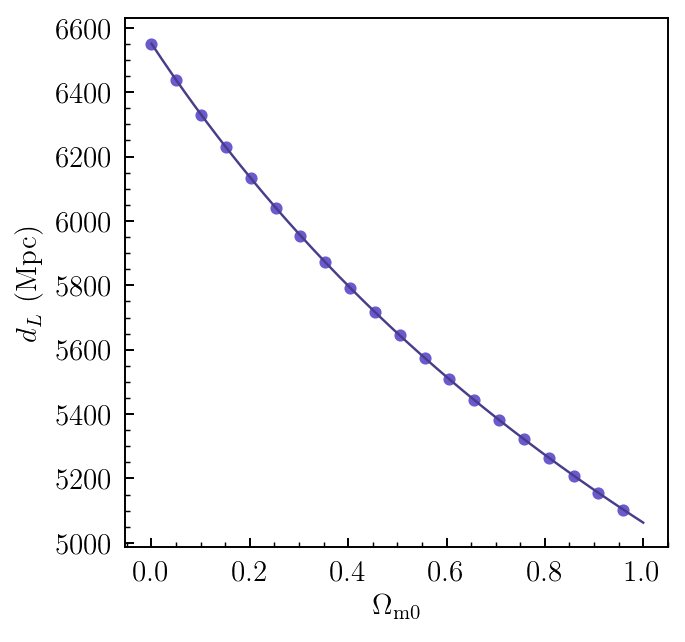

In [441]:
plot_line_points(Om0test, dLtest, xp=Om0tr, yp=dLtr, points=True,
                 xlabel=r'$\Omega_{\rm m0}$', ylabel=r'$d_L\rm\ (Mpc)$', figsize=4)

In [442]:
frac_err_poly   = np.log10(np.maximum(np.abs(1.0-dLpoly/dLtest), 2.e-16))
frac_err_poly2  = np.log10(np.maximum(np.abs(1.0-dLpoly2/dLtest), 2.e-16))
frac_err_spline = np.log10(np.maximum(np.abs(1.0-dLspline/dLtest), 2.e-16))

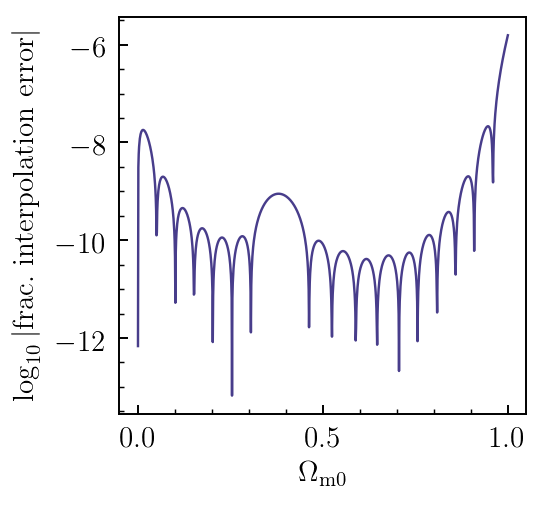

In [443]:
# notice the array slicing, ::nss selects every nss-th element of the array
plot_line_points(Om0test, frac_err_poly,
                 xlabel=r'$\Omega_{\rm m0}$', 
                 ylabel=r'$\log_{10}\vert\rm frac.\ interpolation\ error\vert$', figsize=3)


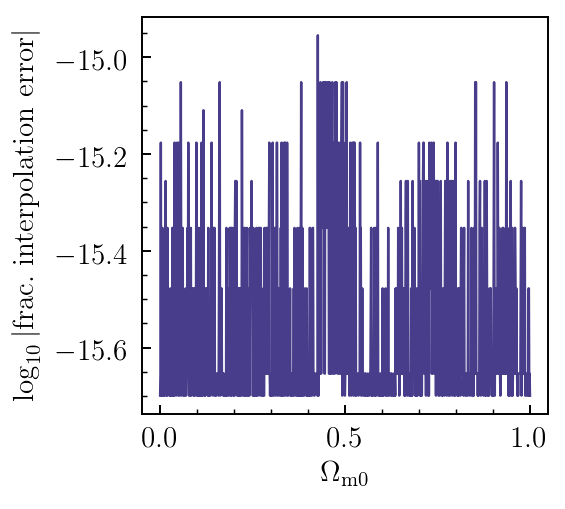

In [444]:
plot_line_points(Om0test, frac_err_poly2,
                 xlabel=r'$\Omega_{\rm m0}$', 
                 ylabel=r'$\log_{10}\vert\rm frac.\ interpolation\ error\vert$', figsize=3)


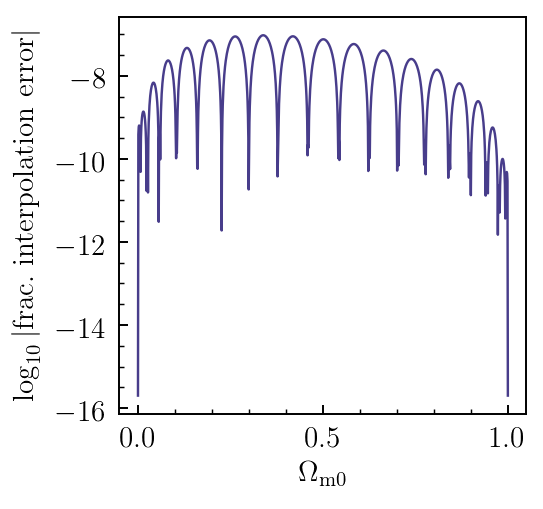

In [445]:
plot_line_points(Om0test, frac_err_spline,
                 xlabel=r'$\Omega_{\rm m0}$', 
                 ylabel=r'$\log_{10}\vert\rm frac.\ interpolation\ error\vert$', figsize=3)


In [411]:
tstart = timeit.default_timer()
for i, Omd in enumerate(Om0test):
    dLtest[i] = d_L_vectorized(z, H0, Omd, OmL[nsOmL], atol=atol, rtol=rtol)

print("Romberg execution time = %.8g sec"%(timeit.default_timer()-tstart))


Romberg execution time = 0.9934088 sec


In [426]:
# equidistant training points
tstart = timeit.default_timer()
porder = np.size(Om0tr)
#pfit = np.poly1d(np.polyfit(Om0tr, dLtr, porder))
#dummy = pfit(Om0test)
dummy = barycentric_interpolate(Om0tr, dLtr, Om0test)
print("polyfit execution time = %.8g sec"%(timeit.default_timer()-tstart))

# Chebyshev training points
tstart = timeit.default_timer()
pfit = np.poly1d(np.polyfit(Om0tr2, dLtr2, porder))
dummy = pfit(Om0test)
print("polyfit execution time = %.8g sec"%(timeit.default_timer()-tstart))

# spline of equidistant training points
tstart = timeit.default_timer()
splfit = interp1d(Om0tr, dLtr, kind=3, fill_value="extrapolate")
from scipy.interpolate import UnivariateSpline
splfit = UnivariateSpline(Om0tr, dLtr, s=0.)
dummy = splfit(Om0test)
print("polyfit execution time = %.8g sec"%(timeit.default_timer()-tstart))


polyfit execution time = 0.00094709999 sec
polyfit execution time = 0.0009972 sec
polyfit execution time = 0.0004608 sec


C:\Users\h2_sf\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RankWarning: Polyfit may be poorly conditioned
  # This is added back by InteractiveShellApp.init_path()


### Conclusions

* Polynomial approximation can be highly accurate for smooth functions, such as $d_L$. 


* Accuracy is sensitive to how we approximate and, in particular, on the placement of the training tabulated parameter values.


* For the training parameter values distributed at the Chebyshev nodes, results accurate to near machine precision can be obtained for smooth functions with nearly 1000-fold speed up of calculation! 

* We "trained" a routine to carry out numerical integration without actually doing any explicit numerical integration!

### Caveats 

* The particular conclusions we reached here are applicable to smooth functions that are well approximated by the polynomials (e.g., they have many continunous derivative orders). 

* Results will vary for other types of functions. For example, functions with discontinuous first derivatives make accurate polynomial interpolation with equally spaced training points more or less impossible. 

* Even for smooth functions with continuous derivatives accurate results can only be guaranteed within the interval of the training set $x\in[x_0,x_N]$. Estimates outside of this interval generally quickly become very inaccurate.

### Extrapolation

If we use $\tilde{f}(x)$ constructed using one of these approaches for $x<x_0$ or $x>x_N$, this is called ***extrapolation***.

**Warning!** In general extrapolation is dangerous and should not be used as it can result in catastrophic errors, except in special cases, when an informed extrapolation can be made. 

### Error of the polynomial approximation 

Suppose function $f(x)$ has $N+1$ continuous derivatives in the interval $x\in [a,b]$. If it is tabulated at $N+1$ distinct points $\{x_i\}$, $i=0,\ldots,N$ by interpolating 
polynomial of order $N$, $p_N(x)$,  the error of the polynomial approximation over this interval can be bounded as follows. 
$$
\epsilon(x) = f(x) - p_N(x) = \frac{f^{(N+1)}(\xi)}{(N+1)!}\,\prod_{i=0}^N(x-x_i),
$$

where $\xi$ is some point within $[a,b]$. 

### Why is the training point placement is so important?

$$d_L = \sum\limits_{i=0}^{p}a_i x^i = a_0 + a_1 x + a_2 x^2 +\ldots + a_p x^p
$$


#### A more sophisticated approach:

1. Tabulate function at some number of parameter values *and* split the tabulated values into the "training", "validation", and "test" samples. The parameter values at which function is evaluated in these three samples are different.



2. Choose an easier to compute function to approximate the actual (computationally expensive) function.


3. Use the "training" sample of tabulated function values to calculate parameters of the approximating function.


4. Use the "validation" sample to estimate how good approximation is and change the approximation (e.g., add more terms to the series) and return to step 3, if the approximation has not reached the target accuracy. If the approximation is deemed sufficiently good, go on to the final step 5.


5. Use the "test" sample of tabulated function values to estimate the accuracy of the final approximation after iterations in steps 3 and 4. 

In [416]:
pcheb = np.polynomial.Chebyshev.fit(Omc, dLvec2, porder)

In [142]:
ccheb = np.polynomial.chebyshev.chebfit(Omc, dLvec2, porder)



C:\Users\h2_sf\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RankWarning: The fit may be poorly conditioned
  """Entry point for launching an IPython kernel.


There are other ways to carry out interpolation or function approximation. For example, we are not limited to equally-spaced tabulated points. We can use other spacing choices, which can lead to much more accurate results in general.

We can also use *piece-wise* interpolation/approximation, whereby function is approximated locally with a polynomial. Such local polynomials can be constrained to provide a smooth global approximation, using the *spline method*. 

Read descriptions of the routines in numpy and scipy that implement these methods <a href="https://mmas.github.io/interpolation-scipy">here</a> as you prepare to embark on the homework assignment. 

### Additional reading

Exposition of polynomial interpolation using barycentric method in this notebook follows closely review paper of <a href="https://people.maths.ox.ac.uk/trefethen/barycentric.pdf">Berrut & Trefethen (2010)</a>, where you can find more details on this method, discussions, and references. 

<a href="https://people.maths.ox.ac.uk/trefethen/mythspaper.pdf">Trefethen (2011)</a> - is a nice, short article about polynomial interpolation and its uses, systematically dispelling many of the existing myths and misconceptions about it. 

### Error of the polynomial approximation: proof 

Suppose function $f(x)$ has $N+1$ continuous derivatives in the interval $x\in [a,b]$. If it is tabulated at $N+1$ distinct points $\{x_i\}$, $i=0,\ldots,N$ by interpolating 
polynomial of order $N$, $p_N(x)$,  the error of the polynomial approximation over this interval can be bounded as follows. 

Consider function
$$
g(\chi) = f(\chi) - p_N(\chi) - [f(x) - p_N(x)]\,\prod\limits_{i=0}^N\frac{(\chi - x_i)}{(x-x_i)},
$$
where $x\ne x_i$ for any $i$. 
If $p_N$ is interpolating polynomial, $g(\chi=x_i) = 0$ for any $i$ and thus $g(\chi)$ has at least $N+1$ zeroes on $[a,b]$. In addition, it has another zero at $\chi = x$ as can be easily seen from the above equation and thus $g(\chi)$ has at least $N+2$ distinct zeroes on the interval. Between each pair of zero points $g^\prime = dg/d\chi$ must change sign and so $g^\prime$ must have zero on the $N+1$ intervals formed by the zeroes of $g(\chi)$. The same logic applied to the $N+1$ zeros of $g^\prime$ leads to the conclusion that $g^{\prime\prime}$ has $N$ zeroes, and so on until we conclude that $g^{(N+1)}$ has one zero at some $\chi=\xi$. Note that $(N+1)$-th derivative of $p_N(\chi)$ is zero and that the leading (largest power) term of expanded $\prod_{i=0}^N(\chi-x_i)$ will be $\chi^{N+1}$ and so the $(N+1)$-th derivative of this product will be $(N+1)!$ and so
$$
\frac{d^{N+1}g(\xi)}{d\chi^{N+1}} = 0 = \frac{d^{N+1}f(\xi)}{d\chi^{N+1}}  - [f(x) - p_N(x)]\,\frac{(N+1)!}{\prod_{i=0}^N(x-x_i)},
$$
which gives
$$
\epsilon(x) = f(x) - p_N(x) = \frac{f^{(N+1)}(\xi)}{(N+1)!}\,\prod_{i=0}^N(x-x_i),
$$
where $\xi$ is a point within interval $[a,b]$. 
